##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [128]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$','Upland':'F$_{up}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$'}

pd.set_option('max_colwidth',200)

In [713]:
class ResultMap:
    def __init__(self,target,SE_Rule=1):
        self.SE_Rule = SE_Rule
        self.target = target
        self.params = Dense.Params(Scope,target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)

        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        Best = level_best.loc[level_best['Performance']==2]
        print(Best)
        try:
            self.Best = Best.loc[Best['Size']==Best['Size'].max()]
    #         self.Model_Selection = self.Best.copy()
            self.Model_Selection = self.Best['Model'].values[0]
        except:
            self.Model_Selection = self.Min['Model'].values[0]
            pass
        self.level_best = level_best
            
        
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+'/'+self.target+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(self.params['K']))):
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.05,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5) 

class Display:
    def __init__(self,targets,target_names):
    
        self.target_options={}
        self.target_names=target_names
        for target,name in zip(targets,target_names):
            self.target_options[name]=target
        self.i = 0
        self.Reset('b')
        
    def Reset(self,b):
        button2 = widgets.Button(description="Reset")
        display(button2)
        button2.on_click(self.Clear) 
        self.Select('b')
            
        
    def Select(self,b):
        self.target = self.target_options[self.target_names[self.i]]
        print('Select Model for: ',self.target_names[self.i])
        self.size = widgets.IntSlider(
            value=self.target.Best['Size'].values[0],
            min=1,
            max=self.target.level_best['Size'].max(),
            step=1,
            description='Model Size:',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        display(self.size)
        button = widgets.Button(description="Query Models")
        display(button)
        button.on_click(self.Select_Models) 
    
    def Clear(self,b):
        clear_output()
        self.i = 0
        self.Reset('b')
        
    def Select_Models(self,b):
        self.Model_Selection = widgets.Select(
        options=self.target.Records.loc[self.target.Records['Size']==self.size.value,'Model'].values,
        value=self.target.level_best.loc[self.target.level_best['Size']==self.size.value,'Model'].values[0],
        # rows=10,
        layout=Layout(width='100%'),
        description='Model:',
        disabled=False
        )
        display(self.Model_Selection)
               
        button = widgets.Button(description="Analyze This Model")
        display(button)
        button.on_click(self.Choose)
        
    def Choose(self,b):
        self.target.Model_Selection = self.Model_Selection.value
        self.i +=1
        if self.i < len(self.target_names):
            self.Select('b')



<IPython.core.display.Javascript object>


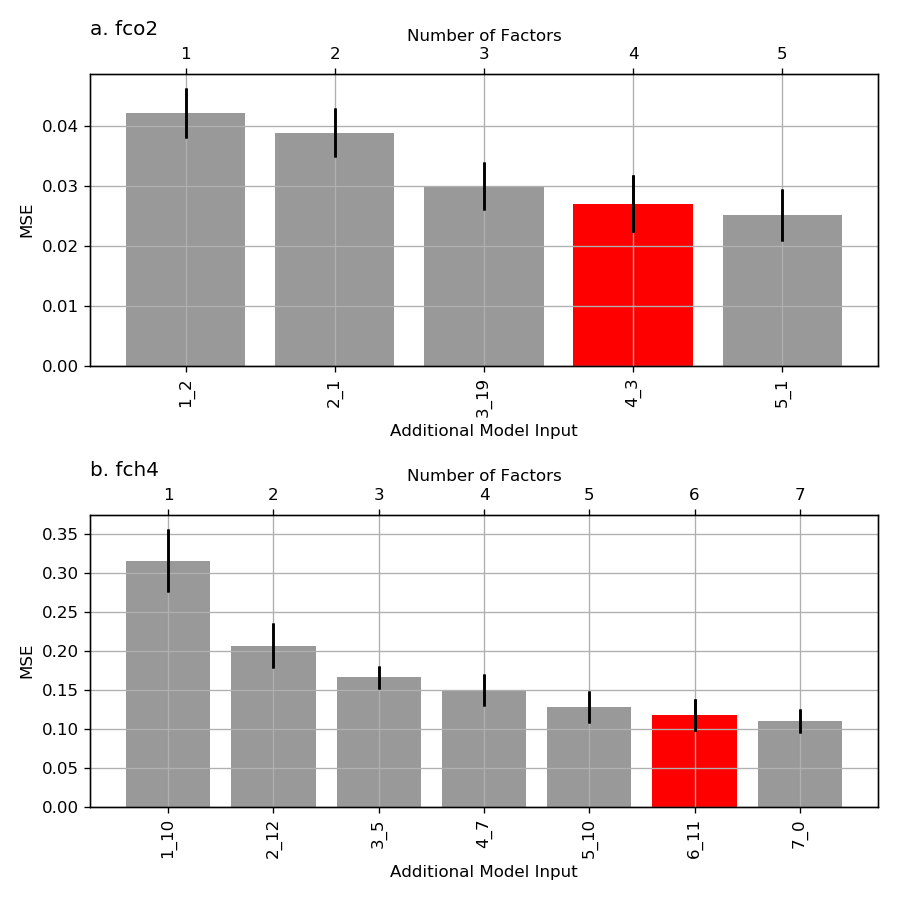

                                       Model       MSE        SE
2                                   PPFD_Avg  0.042204  0.004168
12                     air_pressure+PPFD_Avg  0.038882  0.004137
40                    PPFD_Avg+AirTC_Avg+VWC  0.029947  0.003989
54               PPFD_Avg+AirTC_Avg+Temp+VWC  0.027038  0.004734
60  air_pressure+PPFD_Avg+AirTC_Avg+Temp+VWC  0.025147  0.004300
                                                         Model       MSE  \
10                                                      Upland  0.316174   
23                                                   VWC+Sedge  0.206845   
35                                              Temp+VWC+Sedge  0.165906   
46                                    AirTC_Avg+Temp+VWC+Sedge  0.149187   
64                             wind_speed+Temp+VWC+Sedge+Shrub  0.128375   
99                wind_speed+PPFD_Avg+AirTC_Avg+Temp+VWC+Sedge  0.117293   
131  wind_speed+air_pressure+PPFD_Avg+AirTC_Avg+Temp+VWC+Sedge  0.109837   

 

In [872]:
def Performance(ax,title,target):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    plt.sca(ax)
    plt.grid()
    plt.xticks(target.level_best['Size'],target.level_best['Model_Key'],rotation=90)
    print(target.level_best[['Model','MSE','SE']])

    
MP=False
Scope = 'Test'
cwd = os.getcwd()
# cwd = 'C:\\Users\\wesle\\Backup'
Site='Illisarvik'
Fill = False


fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
Performance(ax[0],'a. fco2',fco2)
Performance(ax[1],'b. fch4',fch4)
plt.tight_layout()


<IPython.core.display.Javascript object>


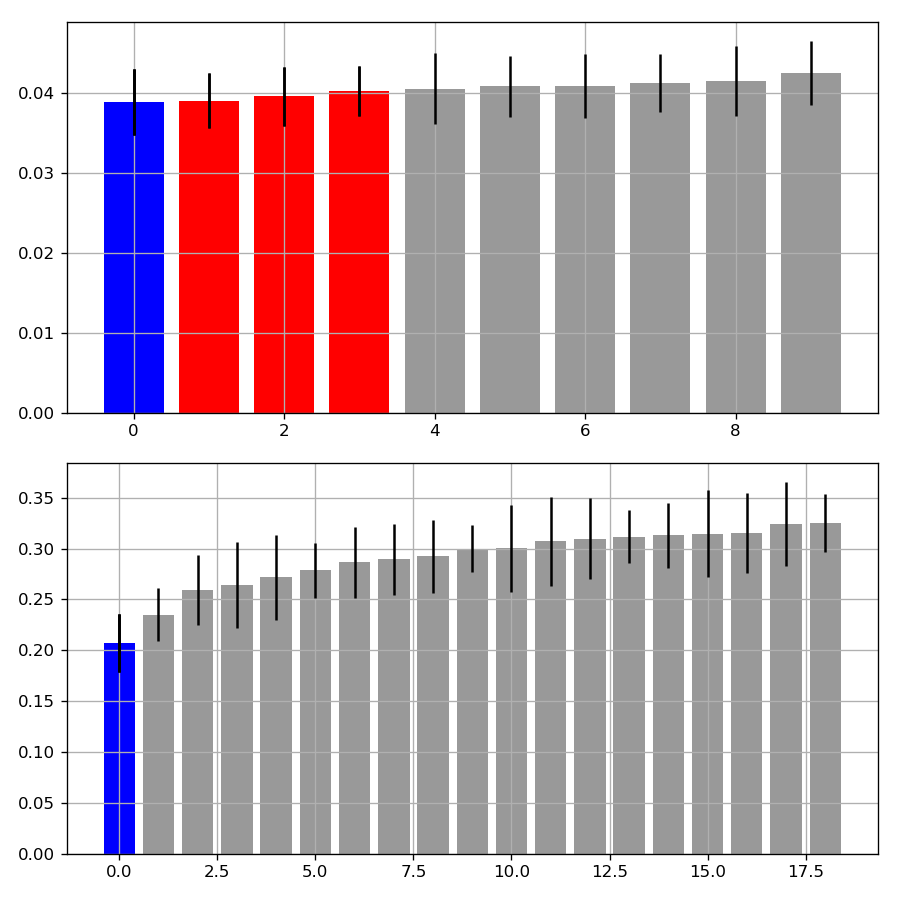

   index                  Model       MSE  Size  Number        SE  \
0     12  air_pressure+PPFD_Avg  0.038882     2       1  0.004137   
1     14           PPFD_Avg+VPD  0.039050     2       3  0.003421   
2     11    wind_speed+PPFD_Avg  0.039604     2       0  0.003721   
3     13     PPFD_Avg+AirTC_Avg  0.040253     2       2  0.003098   

   Performance         T        T2 Model_Key  
0            2  0.000000 -3.097984       2_1  
1            2  0.170821 -3.203828       2_3  
2            2  0.709919 -2.549032       2_0  
3            2  1.452460 -2.057674       2_2  
   index       MSE      Model  Number  Performance        SE  Size    T  \
0     23  0.206845  VWC+Sedge      12            2  0.028573     2  0.0   

          T2 Model_Key  
0 -12.008414      2_12  
Counter({'PPFD_Avg': 30, 'wind_speed': 9, 'air_pressure': 9, 'AirTC_Avg': 9, 'VPD': 9, 'Temp': 4, 'VWC': 4, 'Sedge': 4, 'Shrub': 4, 'Grass': 4, 'Upland': 4})


In [880]:
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Best = Data[Data['Performance']==1]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    else:
        Best = Data[Data['Performance']==2]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    ax.grid()
fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=2)
LevelPerformance(ax[1],'b. fch4',fch4,level=2)
plt.tight_layout()
Ultimate = []
for val in (fco2.Records.loc[fco2.Records['Size']==3,'Model'].str.split('+').values):
    Ultimate+=val
# print(Ultimate)
from collections import Counter
print(Counter(Ultimate))

In [714]:

fco2 = ResultMap('fco2')
fch4 = ResultMap('fch4')

Disp = Display([fco2,fch4],['fco2','fch4'])
fco2 = Disp.target_options['fco2']
fch4 = Disp.target_options['fch4']

A Jupyter Widget

Select Model for:  fco2


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Select Model for:  fch4


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


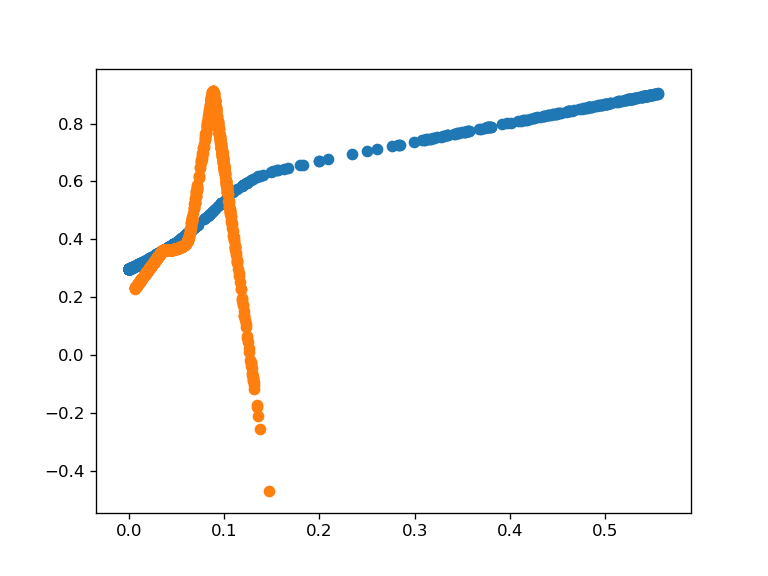

__main__
__main__


In [878]:
# fco2.Project(Projector = None,
#                 Model = None)
# fco2.Map()
# plt.figure()
# plt.scatter(fco2.Data_Map['AirTC_Avg'],fco2.Data_Map[fco2.target])

plt.figure()


fch4.Project(Projector = None,
                Model = 'Sedge')
fch4.Map()
plt.scatter(fch4.Data_Map['Sedge'],fch4.Data_Map[fch4.target])



fch4.Project(Projector = None,
                Model = 'Upland')
fch4.Map()
plt.scatter(fch4.Data_Map['Upland'],fch4.Data_Map[fch4.target])



<IPython.core.display.Javascript object>


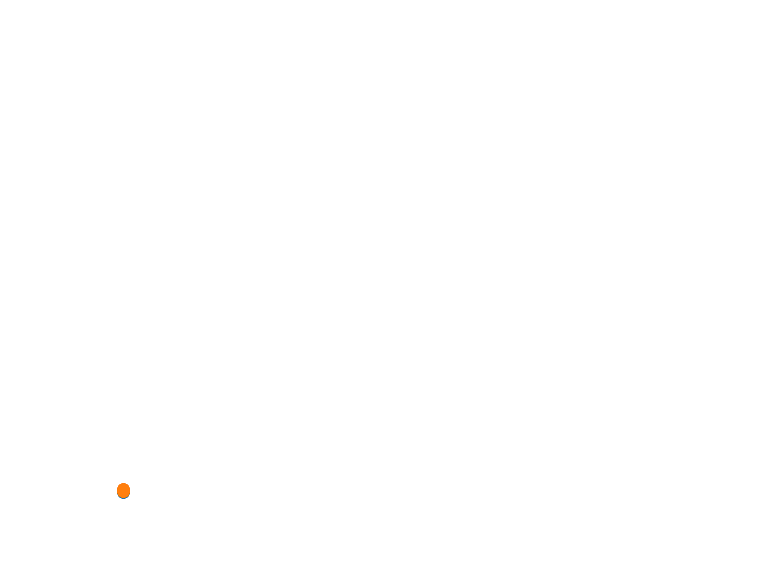

__main__
__main__


In [881]:

plt.figure()
fch4.Project(Projector = None,
                Model = 'VWC+Upland')
fch4.Map()
plt.scatter(fch4.Data_Map['Upland'],fch4.Data_Map[fch4.target])


fch4.Project(Projector = None,
                Model = 'VWC+Sedge')
fch4.Map()
plt.scatter(fch4.Data_Map['Sedge'],fch4.Data_Map[fch4.target])



<IPython.core.display.Javascript object>


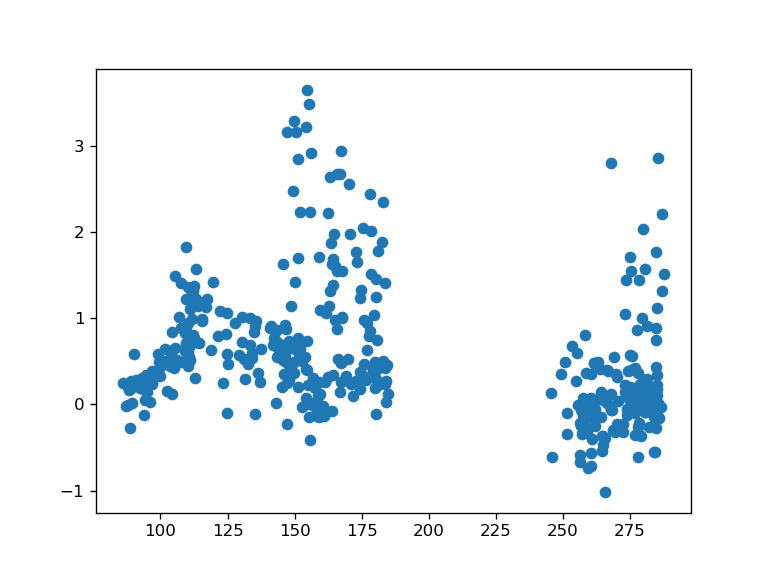

In [888]:
plt.figure()
plt.scatter(T30.loc[T30['Upland']>.05,'wind_dir'],T30.loc[T30['Upland']>.05,'fch4'])

In [803]:
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

T30 = fco2.RST.Master.copy()

T30 = T30.loc[((T30['DOY']>=193) & (T30['DOY']<220))]
T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
Vars = ['AirTC_Avg','PPFD_Avg','wind_speed','Rain_mm_Tot','VPD','DOY','DOY2','Temp','VWC']
test = T30[Vars].dropna()
Key = Vars[0:3]
forest=LinearRegression().fit(test[Key],test['Temp'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','Temp']].dropna()
print(metrics.mean_squared_error(test['TempFIll'],test['Temp']))
T30['Temp']=T30['Temp'].fillna(T30['TempFIll'])
test = T30[Vars].dropna()
Key=['DOY','DOY2','Temp','Rain_mm_Tot']#,Vars[2:7]
# forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
forest = LinearRegression().fit(test[Key],test['VWC'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','VWC',]].dropna()
print(metrics.mean_squared_error(test['TempFIll'],test['VWC']))
T30['VWC']=T30['VWC'].fillna(T30['TempFIll'])

H1 = T30.resample('24H').mean()
T30_Dark = T30.copy()
T30_Dark['PPFD_Avg']=0



def Kitty(AllData,target,target_name,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
#     if target_name == 'NME':
#         target.RST.Data['fch4']=28*1e-3
    target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True)
    target.Map()
    if target_name != 'ER':
        AllData[target_name] = AllData[target.target]+0.0
        AllData[target_name+'_fill'] = target.Data_Map[target.target].values
        AllData[target_name] = AllData[target_name].fillna(AllData[target_name+'_fill'])
    else:
        AllData[target_name] = target.Data_Map[target.target].values
    AllData[target_name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[target_name+'_Var_er'] = target.Data_Map['Var_er'].values
    return(AllData)

T30 = Kitty(T30,fco2,'ER',T30_Dark)
T30 = Kitty(T30,fco2,'NEE')
T30 = Kitty(T30,fch4,'NME')

T30['ER_pred'] = T30['ER']+0.0

T30.loc[T30['PPFD_Avg']<10.0,'ER']=T30.loc[T30['PPFD_Avg']<10.0,'fco2']

T30['GPP']=T30['NEE']-T30['ER']
T30.loc[(T30['GPP']>0)&(T30['ER_pred']<T30['fco2']),'ER']=T30.loc[(T30['GPP']>0)&(T30['ER_pred']<T30['fco2']),'fco2']

T30['GPP']=T30['NEE']-T30['ER']

1.9418144020763302
1.7311300383459443e-05
__main__
__main__
__main__


<IPython.core.display.Javascript object>


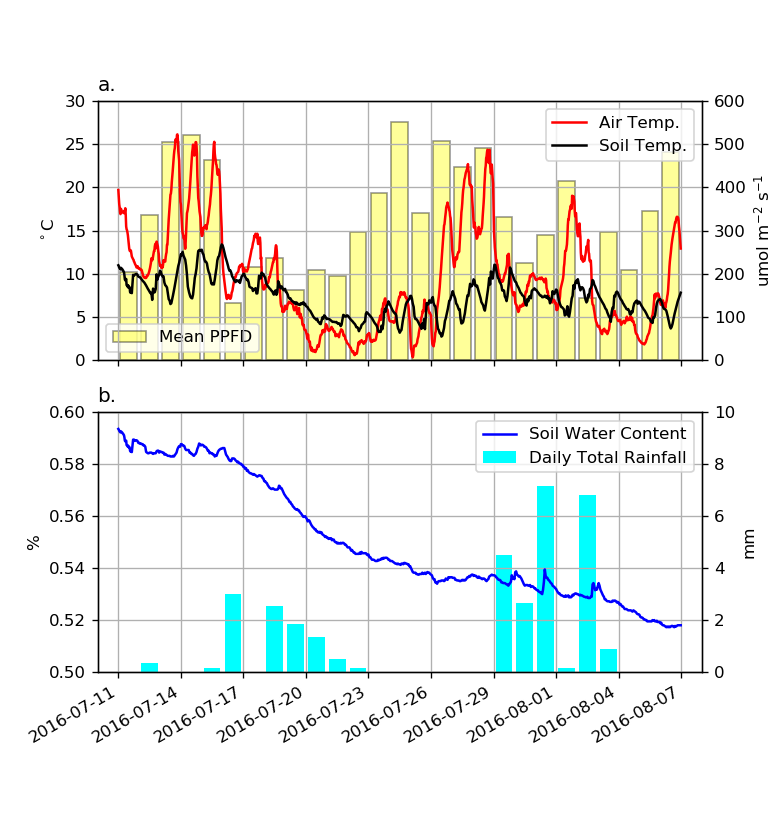

NEE:  -0.23173654926865028 0.0280720557360877
NME:  0.49436155871129744 0.03276748051914941
NME - co2 eq:  0.01384212364391633 0.0009174894545361836
-0.21789442562473396 0.014494772595311942
ER:  0.3713087737560272 0.2829770651391562
-0.5984616146368932
ER: r2  0.8657470925632338
ER: MSE  0.049467607447382135


<IPython.core.display.Javascript object>


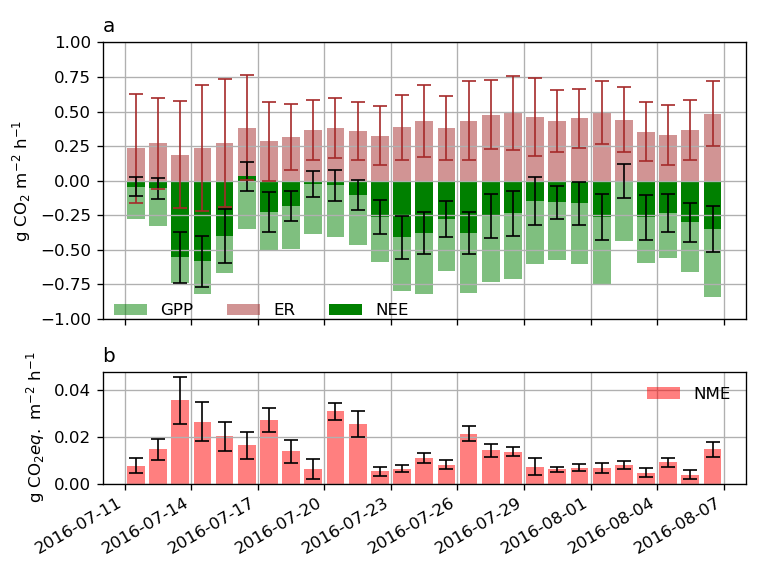

<IPython.core.display.Javascript object>


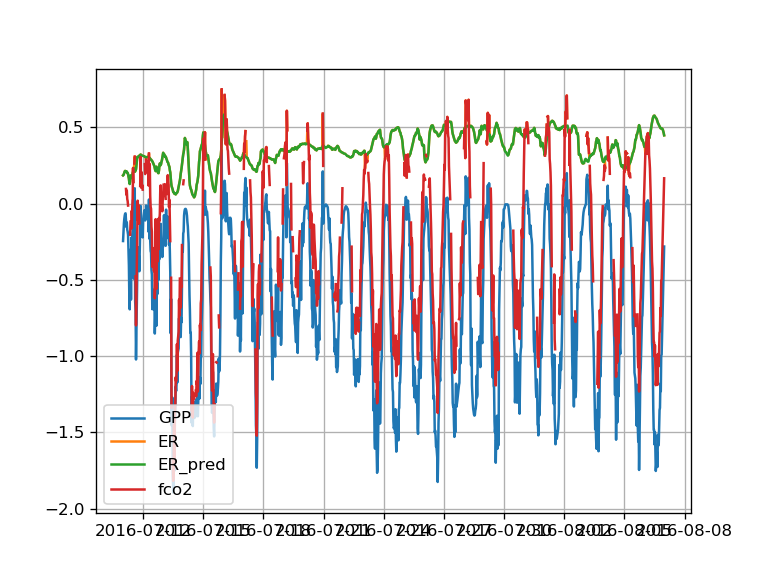

wind_dir       228.685450
fco2             0.457031
Upland           0.070120
GPP              0.080310
ER               0.457031
ER_pred          0.376722
PPFD_Avg        23.110180
Rain_mm_Tot      0.000000
dtype: float64
wind_dir       88
fco2           88
Upland         88
GPP            88
ER             88
ER_pred        88
PPFD_Avg       88
Rain_mm_Tot    88
dtype: int64


In [839]:


fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)


# print(Tepmp)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'Air Temp.')
ax[0].plot(T30['Temp'],color='black',label = 'Soil Temp.')
# ax[0].bar(H1.index,H1['PPFD_Avg']*np.nan,color='yellow',alpha=.4,edgecolor='black',label = 'Mean PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['PPFD_Avg'],color='yellow',alpha=.4,edgecolor='black',label = 'Mean PPFD')
yax2.set_ylim(0,600)
ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('umol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend()
yax2.legend(loc=3)
ax[0].set_title('a.',loc='left')

yax2 = ax[1].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['Rain_mm_Tot']*48,color='cyan',label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,color='cyan',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
# ax[1].set_ticks([.])
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].legend()
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_title('b.',loc='left')


fig.autofmt_xdate()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)



# fig,ax = plt.subplots(1,1,figsize = (5,7))
# test = T30[['fco2','ER_fill']].dropna()
# ax[0].scatter(T30['fco2'],T30['ER_fill'])
# Line = LinearRegression().fit(test['fco2'].values.reshape(-1,1),test['ER_fill']).predict(test['fco2'].values.reshape(-1,1))
# ax[0].plot(test['fco2'],Line,color = 'black',
#        label = 'r2: '+str(metrics.r2_score(test['fco2'],test['ER_fill'])))
# #                   'r2: '))#+str(metrics.r2_score(test['fco2'],test['fco2_fill']))))
# ax[0].grid()
# ax[0].legend()

# # test = T30[['fch4','fch4_fill']].dropna()
# # ax[1].scatter(T30['fch4'],T30['fch4_fill'])
# # Line = LinearRegression().fit(test['fch4'].values.reshape(-1,1),test['fch4_fill']).predict(test['fch4'].values.reshape(-1,1))
# # ax[1].plot(test['fch4'],Line,color = 'black',
# #        label = 'r2: '+str(metrics.r2_score(test['fch4'],test['fch4_fill'])))
# # #                   'r2: '))#str(metrics.r2_score(test['fch4'],test['fch4_fill']))))
# # ax[1].grid()
# # ax[1].legend()
# print('poo')
# # T30[['Var_reg','Var_er']]=fco2.Data_Map[['Var_reg','Var_er']].values


H1 = T30.resample('24H').mean()
H1['Cbal'] = H1['NEE']+H1['NME']*28*1e-3
H1['ER_CI'] = 1.96*H1['ER_Var_reg']**.5
H1['ER_PI'] = 1.96*((H1['ER_Var_er']+H1['ER_Var_reg'])**.5)
H1S = T30.resample('24H').std()



# fig,ax = plt.subplots(1,1,figsize = (6,6.5),sharex=True)
# ax.bar(H1.index,H1['fco2_filled'],
#        yerr = H1S['fco2_filled']/(48)**.5*stats.t.ppf(1-.025,48),
#        color='green',alpha=.5,edgecolor='black',
#        error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))
# ax.set_ylim(-0.8,.15)
# ax2=ax.twinx()
# ax.bar(H1.index,H1['fch4_filled']*28*1e-3,
#        yerr = H1S['fch4_filled']/(48)**.5*stats.t.ppf(1-.025,48)*28*1e-3,
#        color='red',alpha=.5,edgecolor='black',
#       error_kw=dict(ecolor='gray', lw=1, capsize=4, capthick=1))


# ax2.plot(H1['CbalSum']*48,color = 'black')
# ax2.set_ylim(-300,56.7)
# ax.grid()
# ax.set_zorder(ax.get_zorder()+1)
# ax.patch.set_visible(False)
# ax.set_ylabel('g CO${_2} eq. $ m$^{-2}$ d$^{-1}$')
# ax.set_ylabel('g CO${_2} eq. $ m$^{-2}$')
# fig.autofmt_xdate()




# T30['NME'] = T30['NME']

print('NEE: ',T30['NEE'].mean(),
      T30['NEE'].std()/(T30['NEE'].count()**.5) *stats.t.ppf(1-.025,T30['NEE'].count()))
print('NME: ',T30['NME'].mean(),
      T30['NME'].std()/(T30['NME'].count()**.5) *stats.t.ppf(1-.025,T30['NME'].count()))
print('NME - co2 eq: ',T30['NME'].mean()*28*1e-3,
      T30['NME'].std()/(T30['NME'].count()**.5) *stats.t.ppf(1-.025,T30['NME'].count())*28*1e-3)

pooled = (T30['NME'].count()*T30['NME'].sem()*28*1e-3+T30['NEE'].count()*T30['NEE'].sem())/(T30['NME'].count()+T30['NEE'].count())

print(T30['NME'].mean()*28*1e-3+T30['NEE'].mean(),
     pooled*stats.t.ppf(1-.025,T30['NME'].count()))



Var_reg = T30['ER_Var_reg'].mean()
Var_er = T30['ER_Var_er'].mean()
print('ER: ',T30['ER'].mean(),
      1.96*((Var_er+Var_reg)**.5))
print(T30['GPP'].mean())
test = T30.loc[T30['PPFD_Avg']<=20,['fco2','ER']].dropna()
print('ER: r2 ',metrics.r2_score(test['fco2'],test['ER']))
print('ER: MSE ',metrics.mean_squared_error(test['fco2'],test['ER'])**.5)

# fig,ax = plt.subplots()
# ax.plot(fco2.Data_Map['fco2']) 
# ax.fill_between(fco2.Data_Map['fco2'].index,
#                 fco2.Data_Map['fco2']-fco2.Data_Map['PI'], 
#                 fco2.Data_Map['fco2']+fco2.Data_Map['PI'],
#                 facecolor='None',
#                 alpha = .5,
#                 edgecolor = color, 
#                 linestyle=':',
#                 linewidth=2,
#                 label = '90% '+'PI')


# fig,ax = plt.subplots(2,1,figsize = (6.5,6.5),sharex=True)
# fig,ax = plt.subplot(3,1,1,figsize = (6.5,6.5),sharex=True)
# ax0=subplot2grid()
# ax1=subplot2grid()

fig = plt.figure()
ax0 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
ax=[ax0,ax1]

ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['GPP'],
          color='green',
          label='GPP',
          alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['ER'],
          yerr = H1['ER_PI'],
          error_kw=dict(ecolor='brown', lw=1, capsize=4, capthick=1),
          color='brown',label='ER',alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['NEE'],
          yerr = H1S['NEE']/(48)**.5*stats.t.ppf(1-.025,48),
          color='green',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')
ax[0].grid()
ax[0].set_title('a',loc='left')
ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ h$^{-1}$')
ax[0].legend(bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=3,loc=4)
ax[0].set_ylim(-1,1)
ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME']*28*1e-3,
          yerr = H1S['NME']/(48)**.5*stats.t.ppf(1-.025,48)*28*1e-3,
          color='red',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          alpha=.5,
          label ='NME')
ax[1].grid()
ax[1].set_title('b',loc='left')
ax[1].set_ylabel('g CO${_2} eq. $ m$^{-2}$ h$^{-1}$')
# ax[1].set_ylim(0,.05)


ax[0].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].legend(facecolor='None',
         edgecolor='None',)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)

# print(T30[['Sedge','Grass','Shrub','Sparse','Water','Upland']].mean())
# print(T30[['Sedge','Grass','Shrub','Sparse','Water','Upland']].sem()*1.96)

fig,ax = plt.subplots()
# plt.scatter(T30['PPFD_Avg'],T30['NEE'],color='blue')
# plt.scatter(T30['PPFD_Avg'],T30['GPP'],color='red')
ax.plot(T30['GPP'])
ax.plot(T30['ER'])
ax.plot(T30['ER_pred'])
ax.plot(T30['fco2'])
ax.legend()
# ax2=ax.twinx()
# ax2.plot(T30['PPFD_Avg']*-1,c='red')
# fig.autofmt_xdate()

plt.grid()
print(T30.loc[(T30['GPP']>0),
              ['wind_dir','fco2','Upland','GPP','ER','ER_pred','PPFD_Avg','Rain_mm_Tot']].mean())
print(T30.loc[(T30['GPP']>0),
              ['wind_dir','fco2','Upland','GPP','ER','ER_pred','PPFD_Avg','Rain_mm_Tot']].count())






<IPython.core.display.Javascript object>


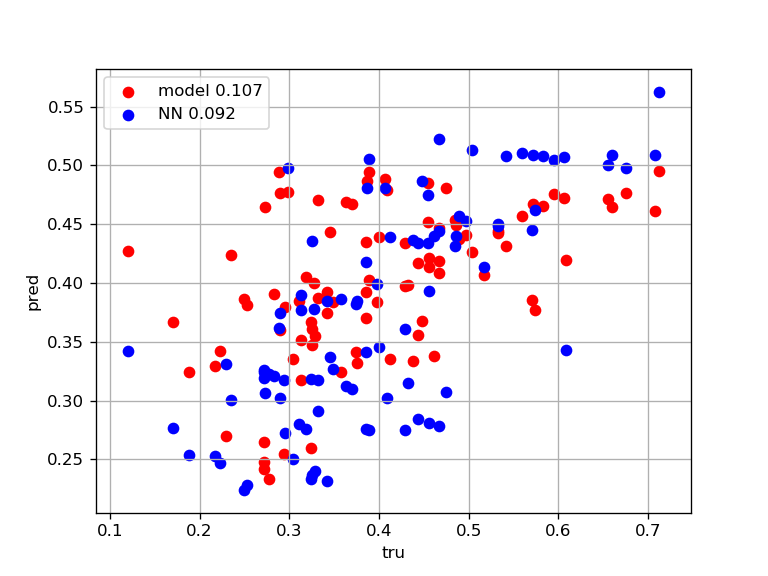

ER     0.371309
ER2    0.378099
dtype: float64
ER:  0.46121317661550876 ER2:  0.2585919064366301
GPP    -0.598462
GPP2   -0.609835
dtype: float64


<IPython.core.display.Javascript object>


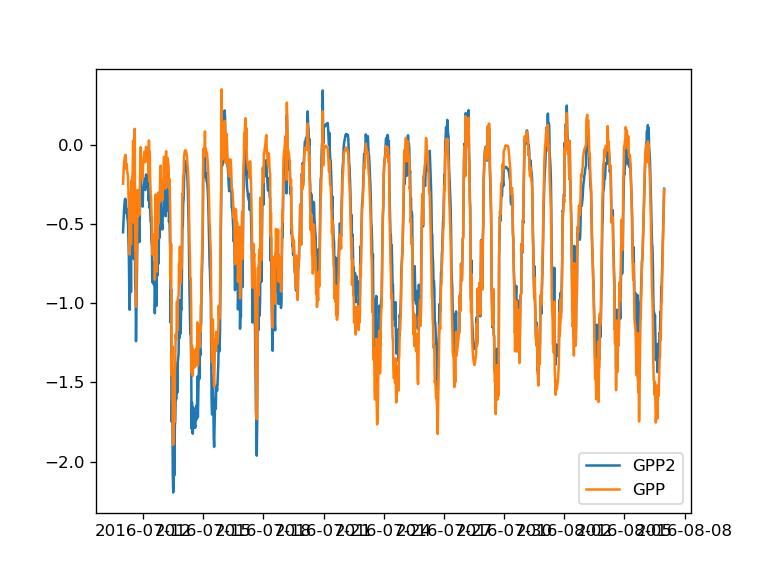

88
124
0.08030976258998261
0.07772285869614227
[77.03371971  0.4798866   2.01113408]


In [866]:

def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_pred']].dropna()
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 74.59262144,0.8875255,2.27508822))
plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='model '+str(np.round(metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,3)))
# plt.scatter(T30['ER_pred'],R_func(T30['Temp'],*popt_r),c='red')
plt.scatter(Dark['fco2'],Dark['ER_pred'],c='blue',
            label='NN '+str(np.round(metrics.mean_squared_error(Dark['fco2'],Dark['ER_pred'])**.5,3)))
# plt.colorbar()
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)

T30['GPP'] = T30['NEE']-T30['ER_pred']
T30['GPP2'] = T30['NEE']-T30['ER2']

print(T30[['ER','ER2']].mean())
print('ER: ',metrics.r2_score(Dark['fco2'],Dark['ER_pred']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)))
print(T30[['GPP','GPP2']].mean())
plt.figure()
plt.plot(T30['GPP2'])
plt.plot(T30['GPP'])
plt.legend()
print(T30.loc[T30['GPP']>0,'GPP'].count())
print(T30.loc[T30['GPP2']>0,'GPP2'].count())
print(T30.loc[T30['GPP']>0,'GPP'].mean())
print(T30.loc[T30['GPP2']>0,'GPP2'].mean())
print(popt_r)

# Model

# Map Results

# Model Comparison

0.060868269654372746


<IPython.core.display.Javascript object>


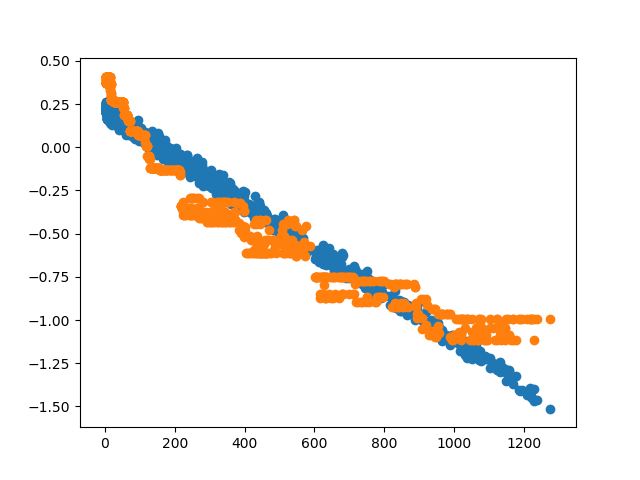

0.034709249460739326


In [358]:
fch4.Project(Projector = None,Model = None)
fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)

forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))

In [513]:
def Plot(ax,Label,Data,regressor,color,target,Interval='CI'):
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    
    ax.plot(Data[regressor],Data[target],
            label= Label,
                color = color)   
    ax.fill_between(Data[regressor],
                    Data[target]-Data[Interval], 
                    Data[target]+Data[Interval],
                    facecolor='None',
                    alpha = .5,
                    edgecolor = color, 
                    linestyle=':',
                    linewidth=2,
                    label = '90% '+Interval)


<IPython.core.display.Javascript object>


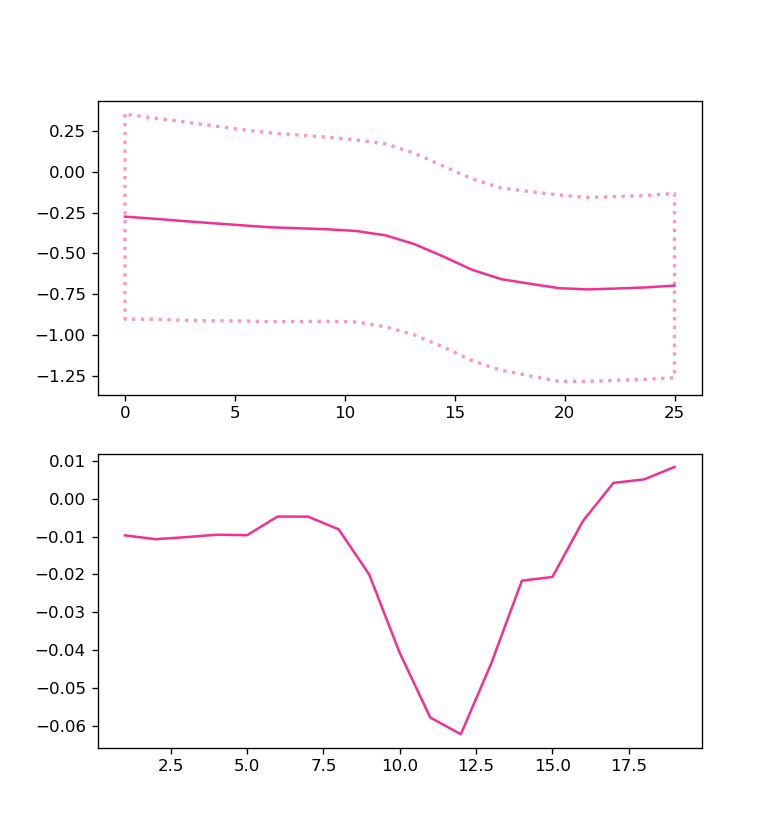

    AirTC_Avg  PPFD_Avg  Temp   VWC  fco2
0    0.000000     500.0  10.0  0.58   0.0
1    1.315789     500.0  10.0  0.58   0.0
2    2.631579     500.0  10.0  0.58   0.0
3    3.947368     500.0  10.0  0.58   0.0
4    5.263158     500.0  10.0  0.58   0.0
5    6.578947     500.0  10.0  0.58   0.0
6    7.894737     500.0  10.0  0.58   0.0
7    9.210526     500.0  10.0  0.58   0.0
8   10.526316     500.0  10.0  0.58   0.0
9   11.842105     500.0  10.0  0.58   0.0
10  13.157895     500.0  10.0  0.58   0.0
11  14.473684     500.0  10.0  0.58   0.0
12  15.789474     500.0  10.0  0.58   0.0
13  17.105263     500.0  10.0  0.58   0.0
14  18.421053     500.0  10.0  0.58   0.0
15  19.736842     500.0  10.0  0.58   0.0
16  21.052632     500.0  10.0  0.58   0.0
17  22.368421     500.0  10.0  0.58   0.0
18  23.684211     500.0  10.0  0.58   0.0
19  25.000000     500.0  10.0  0.58   0.0
__main__
AirTC_Avg


<IPython.core.display.Javascript object>


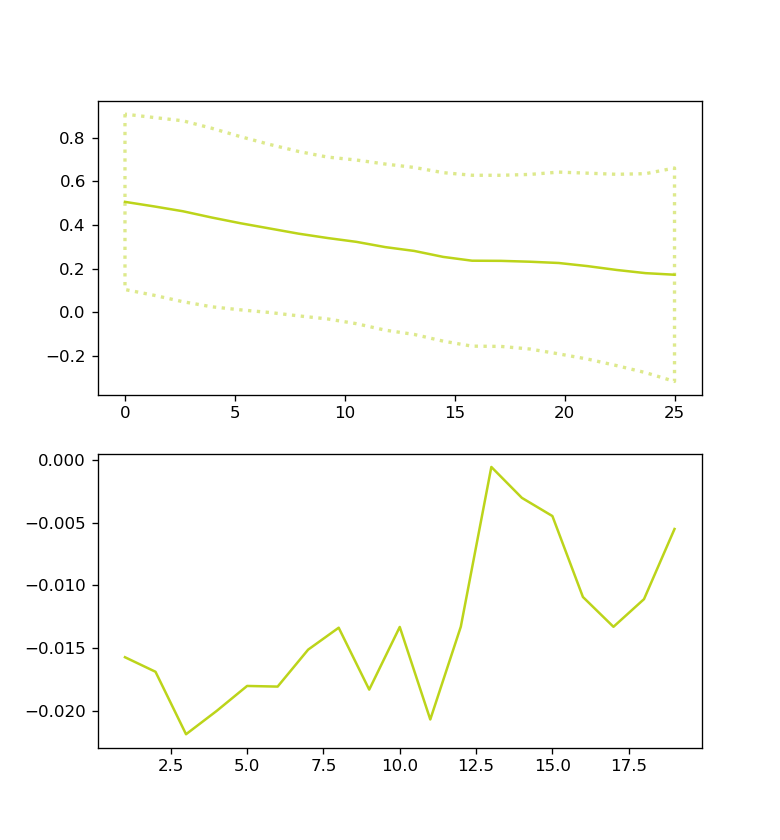

    AirTC_Avg  PPFD_Avg  Temp   VWC  fco2
0    0.000000       0.0  10.0  0.58   0.0
1    1.315789       0.0  10.0  0.58   0.0
2    2.631579       0.0  10.0  0.58   0.0
3    3.947368       0.0  10.0  0.58   0.0
4    5.263158       0.0  10.0  0.58   0.0
5    6.578947       0.0  10.0  0.58   0.0
6    7.894737       0.0  10.0  0.58   0.0
7    9.210526       0.0  10.0  0.58   0.0
8   10.526316       0.0  10.0  0.58   0.0
9   11.842105       0.0  10.0  0.58   0.0
10  13.157895       0.0  10.0  0.58   0.0
11  14.473684       0.0  10.0  0.58   0.0
12  15.789474       0.0  10.0  0.58   0.0
13  17.105263       0.0  10.0  0.58   0.0
14  18.421053       0.0  10.0  0.58   0.0
15  19.736842       0.0  10.0  0.58   0.0
16  21.052632       0.0  10.0  0.58   0.0
17  22.368421       0.0  10.0  0.58   0.0
18  23.684211       0.0  10.0  0.58   0.0
19  25.000000       0.0  10.0  0.58   0.0
__main__
AirTC_Avg


<IPython.core.display.Javascript object>


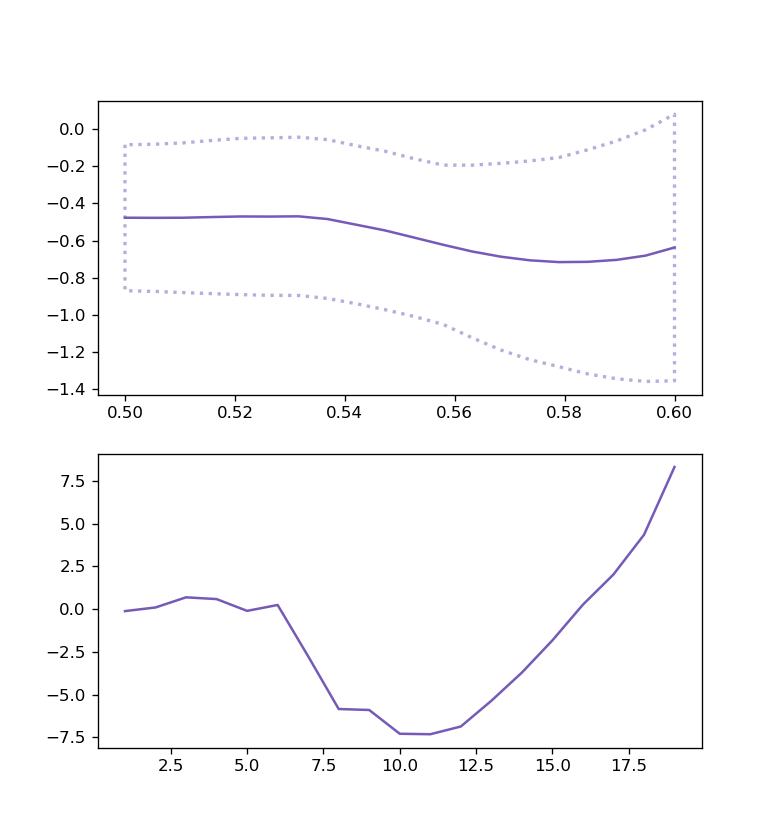

         VWC  PPFD_Avg  Temp  AirTC_Avg  fco2
0   0.500000     500.0  10.0       20.0   0.0
1   0.505263     500.0  10.0       20.0   0.0
2   0.510526     500.0  10.0       20.0   0.0
3   0.515789     500.0  10.0       20.0   0.0
4   0.521053     500.0  10.0       20.0   0.0
5   0.526316     500.0  10.0       20.0   0.0
6   0.531579     500.0  10.0       20.0   0.0
7   0.536842     500.0  10.0       20.0   0.0
8   0.542105     500.0  10.0       20.0   0.0
9   0.547368     500.0  10.0       20.0   0.0
10  0.552632     500.0  10.0       20.0   0.0
11  0.557895     500.0  10.0       20.0   0.0
12  0.563158     500.0  10.0       20.0   0.0
13  0.568421     500.0  10.0       20.0   0.0
14  0.573684     500.0  10.0       20.0   0.0
15  0.578947     500.0  10.0       20.0   0.0
16  0.584211     500.0  10.0       20.0   0.0
17  0.589474     500.0  10.0       20.0   0.0
18  0.594737     500.0  10.0       20.0   0.0
19  0.600000     500.0  10.0       20.0   0.0
__main__
VWC


<IPython.core.display.Javascript object>


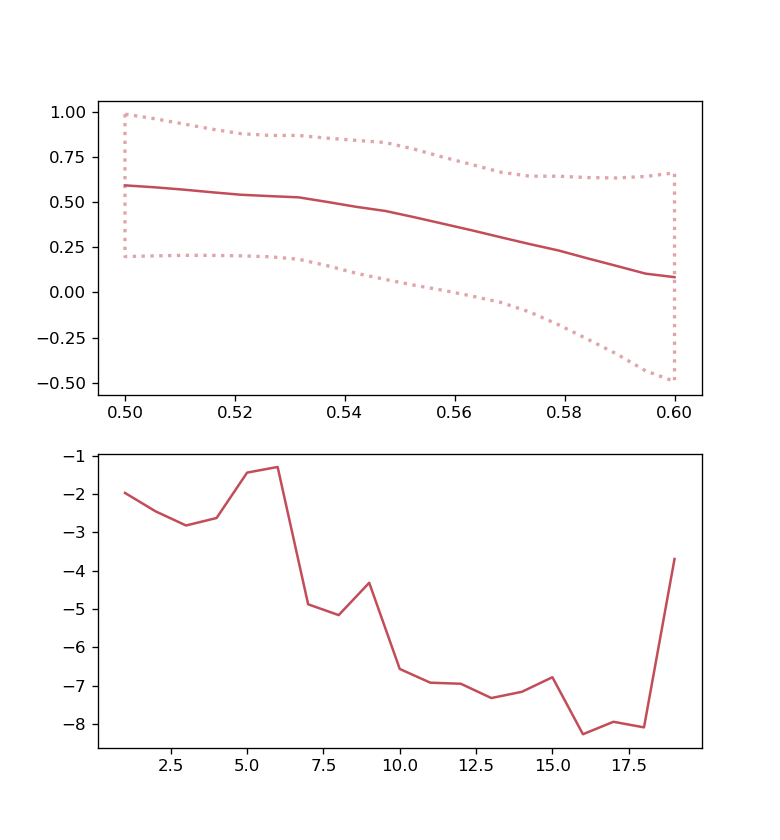

         VWC  PPFD_Avg  Temp  AirTC_Avg  fco2
0   0.500000       0.0  10.0       20.0   0.0
1   0.505263       0.0  10.0       20.0   0.0
2   0.510526       0.0  10.0       20.0   0.0
3   0.515789       0.0  10.0       20.0   0.0
4   0.521053       0.0  10.0       20.0   0.0
5   0.526316       0.0  10.0       20.0   0.0
6   0.531579       0.0  10.0       20.0   0.0
7   0.536842       0.0  10.0       20.0   0.0
8   0.542105       0.0  10.0       20.0   0.0
9   0.547368       0.0  10.0       20.0   0.0
10  0.552632       0.0  10.0       20.0   0.0
11  0.557895       0.0  10.0       20.0   0.0
12  0.563158       0.0  10.0       20.0   0.0
13  0.568421       0.0  10.0       20.0   0.0
14  0.573684       0.0  10.0       20.0   0.0
15  0.578947       0.0  10.0       20.0   0.0
16  0.584211       0.0  10.0       20.0   0.0
17  0.589474       0.0  10.0       20.0   0.0
18  0.594737       0.0  10.0       20.0   0.0
19  0.600000       0.0  10.0       20.0   0.0
__main__
VWC


In [856]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def QQ(target,Range,N):
    
    target.Project(Projector = None,Model = None)
    columns=[Range]
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    scaler = StandardScaler()
    scaler.fit(target.RST.Data[columns[1:]])
    Temp = scaler.transform(target.RST.Data[columns[1:]])
    Temp = pd.DataFrame(data = Temp,columns = columns[1:])
    kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
    Q = scaler.inverse_transform(kmeans.cluster_centers_)
    columns.append('target')
    print(Q)
    def Make(Data,columns,map_range,values,N=20):
        ranges = [np.linspace(map_range[0],map_range[1],N)]
        for v in values:
            ranges.append(np.ones(N)*v)
        ranges.append(np.ones(N)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        return(pd.DataFrame(data = data))
    tarList=[]
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
        Data = Make(target.RST.Data,columns,
                    map_range=[target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()],
                    values=values)
        target.RST.Data=Data
        target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
        target.Map()
        tarList.append(target.Data_Map)        
    return(tarList,Q)

def Mask(target,Value={'PPFD_Avg':0},AD=None):
    
#     print(AD)
    target.Project(Projector = None,Model = None)
    if AltData is None:
        for key, value in Value.items():
            target.RST.Data[key] = value
    else:
        target.RST.Data=AD
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],
                     ScalePath=target.RST.params['Spath'],Project=True)
#     print(target.RST.Data)
    target.Map()
    return(target)
      
    
def Make(Data,columns,map_range,values,N=20):
    ranges = [np.linspace(map_range[0],map_range[1],N)]
    for v in values:
        ranges.append(np.ones(N)*v)
    ranges.append(np.ones(N)*0)
    data = {}
    for (col,ran) in zip(columns,ranges):
        data[col]=ran
    return(pd.DataFrame(data = data))
    
# AltData = Make(target.RST.Data,['AirTC_Avg','PPFD_Avg','Temp','VWC','fco2'],
#                [0,20],[0,5,.55])
# # pd.DataFrame(data = [])
# # print(AltData)
# fco2 = Mask(fco2,AltData=AltData)
# fco2.RST.Data
# # fig,ax=plt.subplots()
# # ax.scatter(fco2.Data_Map['AirTC_Avg'],fco2.Data_Map['fco2'])

target = fco2
differential = 'AirTC_Avg'

for columns,ran,value in zip([['AirTC_Avg','PPFD_Avg','Temp','VWC','fco2'],
                            ['AirTC_Avg','PPFD_Avg','Temp','VWC','fco2'],
                            ['VWC','PPFD_Avg','Temp','AirTC_Avg','fco2'],
                            ['VWC','PPFD_Avg','Temp','AirTC_Avg','fco2']],
                            [[0,25],[0,25],[.5,.6],[.5,.6]],
                             [[500,10,.58],[0,10,.58],[500,10,20],[0,10,20]]):
#     print(columns)
    fig1,ax = plt.subplots(2,1,figsize=(6.5,7))
    AltData = Make(target.RST.Data,columns,
               ran,value)
    print(AltData)
    fco2 = Mask(fco2,AD=AltData)

    differential = columns[0]
    print(differential)
    color = list(np.random.choice(range(256), size=3)/256)
    Plot(ax[0],'Scenario '+str(1),target.Data_Map,differential,color,target.target,Interval = 'PI')
    # ax1 = ax[0]
    ax[1].plot(target.Data_Map[target.target].diff()/target.Data_Map[differential].diff(),color = color)


# colors = ['red','green','blue','purple']
# tarList,means=QQ(target,differential, len(colors))
# fig,ax=plt.subplots(2,1)
# i=0
# for Data,color,mean in zip(tarList,colors,means):
# #     print(np.round(means[i,:],3))
# #     (target.Data_Map)
#     print(Data[['PPFD_Avg','Temp','VWC']].mean())
#     Plot(ax[0],'Scenario '+str(i),Data,differential,color,target.target,Interval = 'PI')
# #     print(Data[target.target].diff())
#     ax[1].plot(Data[target.target].diff()/Data[differential].diff(),color = color)
#     i += 1

# ax[0].legend(ncol=2,loc=2)

# ax[0].grid()
# ax[1].grid()

In [867]:
# # fco2.params['K']=2

# def Scatter(target):
#     Data_Map = target.Data_Map#.sort_values('True')
# # plt.fill_between(Data_Map['True'],
# #                 Data_Map[fco2.target]-Data_Map['CI'], 
# #                 Data_Map[fco2.target]+Data_Map['CI'],
# #                 color = color, alpha = 0.3, 
# #                 label = '95% PI')
# # Temp1=(Data_Map['True'])#[100:200]).values#np.arange(1,10)#
# # Temp2=(Data_Map['fco2'])#[100:200]).values#np.arange(2,11)#
#     plt.figure()
#     plt.scatter(Data_Map['True'],Data_Map[target.target])
#     plt.xlabel('True')
#     plt.ylabel('Pred')
# # print(Temp1,Temp2)
#     print(metrics.r2_score(Data_Map['True'],Data_Map[target.target]))
#     # print(metrics.mean_squared_error(Temp1,Temp2))
#     plt.grid()
# Scatter(fch4)
# SS_Total = ((Temp1-Temp1.mean())**2).sum()
# SS_Residual = ((Temp1-Temp2)**2).sum()
# # r2 = 1 - SS_res/SS_tot


# r_squared = 1 - (float(SS_Residual))/SS_Total
# adjusted_r_squared = 1 - (1-r_squared)*(len(Temp1)-1)/(len(Temp1)-len(fco2.Model_Selection.split('+'))-1)

# print(r_squared,adjusted_r_squared)

# import statsmodels.api as sm
# X1 = sm.add_constant(Temp2)
# result = sm.OLS(Temp1, X1).fit()
# #print dir(result)
# print( result.rsquared, result.rsquared_adj)
# print(((Data_Map['True']-Data_Map['True'].mean())**2).sum()/((Data_Map['fco2']-Data_Map['True'])**2).sum())
# plt.figure()
# plt.scatter(fco2.Data_Map['True'],fco2.Data_Map['CI'])

In [ ]:
# plt.figure()
# plt.scatter(Data_Map['PPFD_Avg'],
# fco2.RST.YScaled.inverse_transform(Data_Map['True']))
# plt.scatter(fco2.RST.Master['PPFD_Avg'],fco2.RST.Master['fco2'])

# y_true = [[0.5, 1], [-1, 1], [7, -6]]
# y_pred = [[0, 2], [-1, 2], [8, -5]]
# r2_score(y_true, y_pred,
#          multioutput='variance_weighted') 

# y_true = [1, 2, 3]
# y_pred = [1, 2, 3]
# r2_score(y_true, y_pred)

# y_true = [1, 2, 3]
# y_pred = [2, 2, 2]
# r2_score(y_true, y_pred)

# y_true = [1, 2, 3]
# y_pred = [3, 2, 1]
# r2_score(y_true, y_pred)